Input Test Images


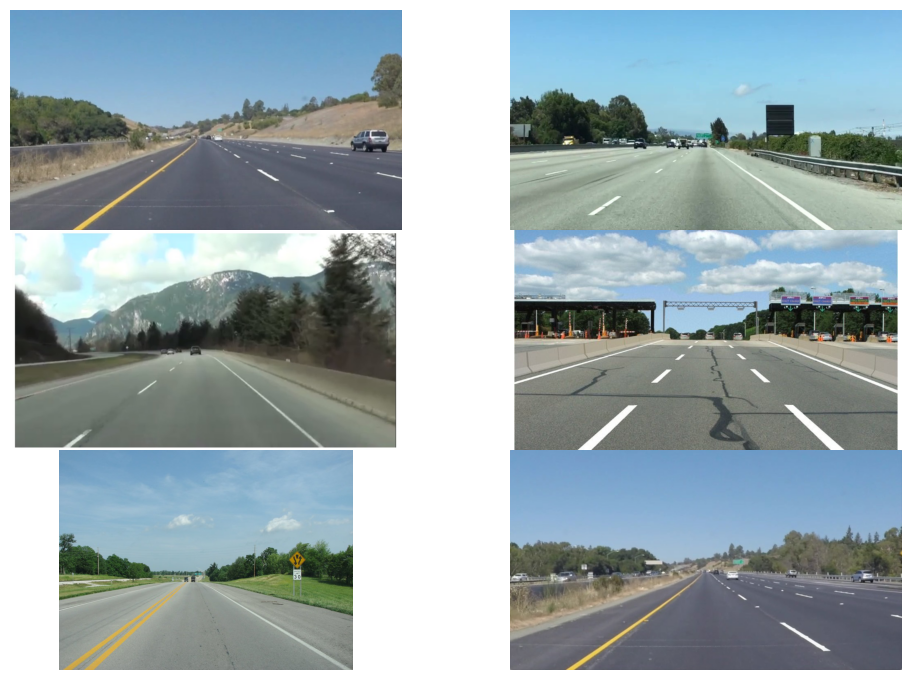

Images after RGB Color Selection


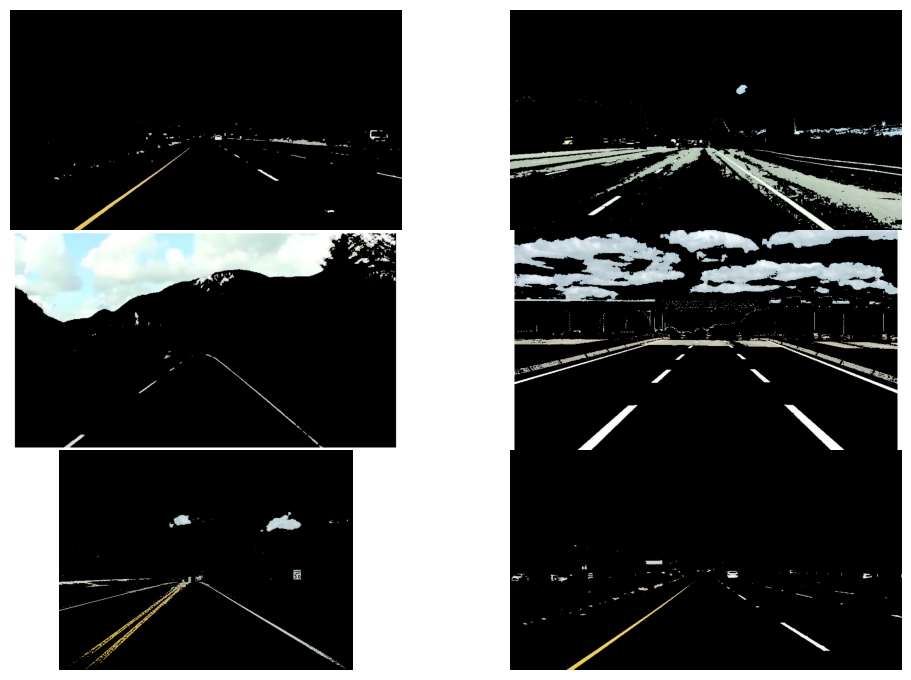

Images converted to HSV Color Space


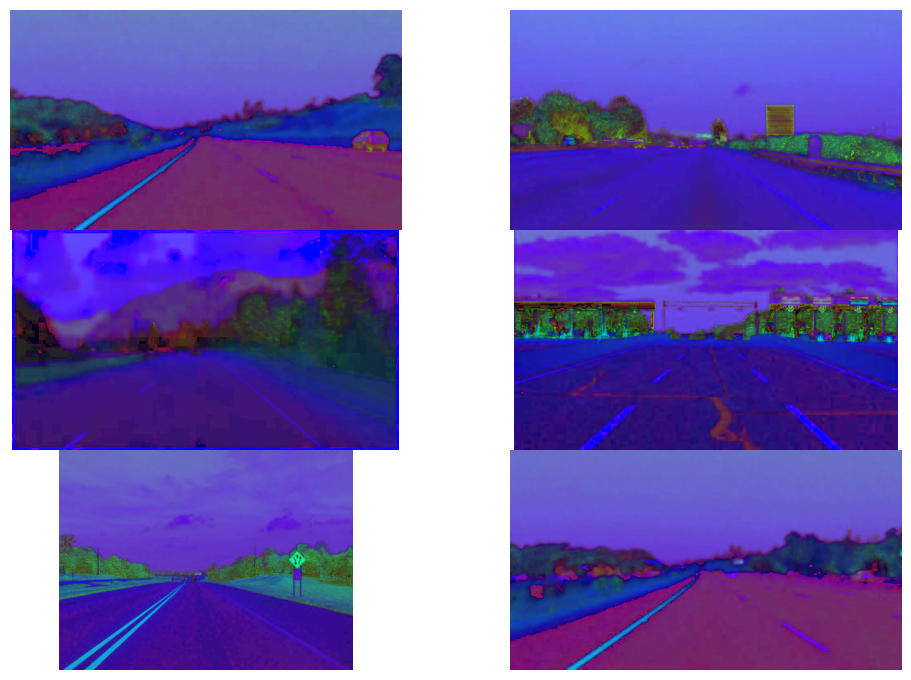

Images after HSV Color Selection


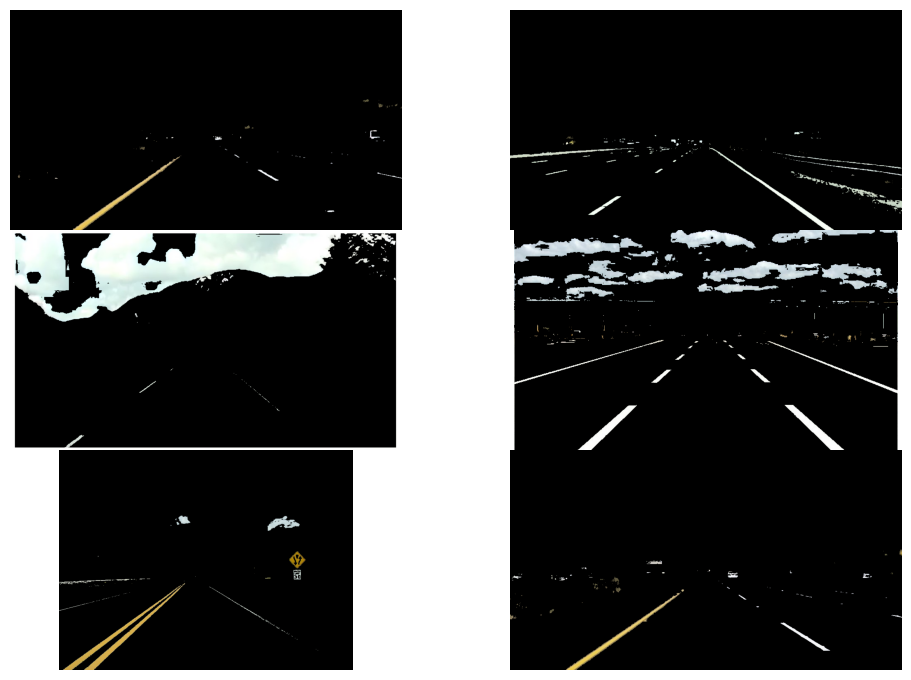

Images converted to HSL Color Space


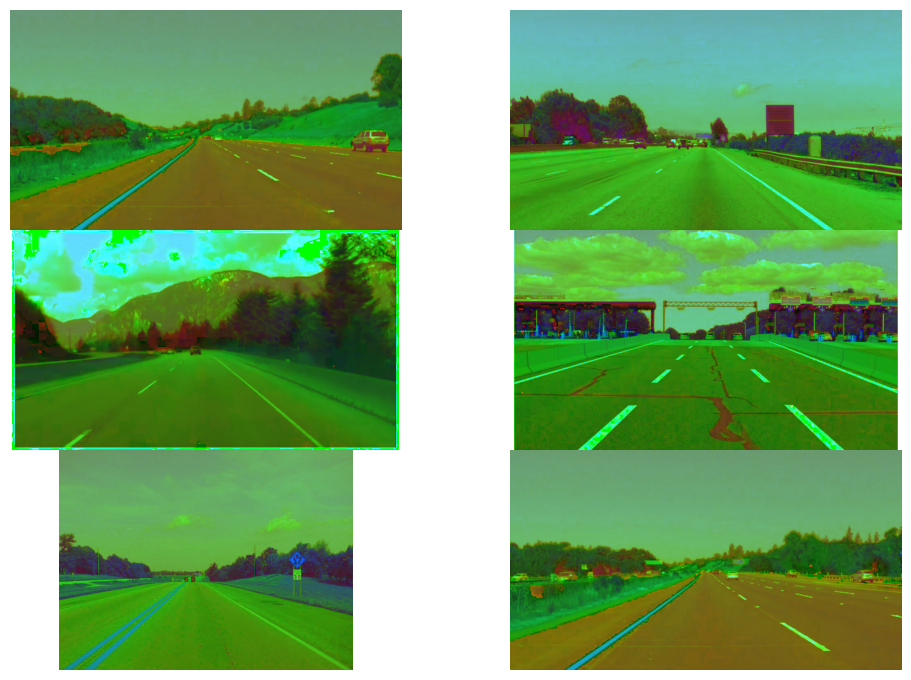

Images after HSL Color Selection


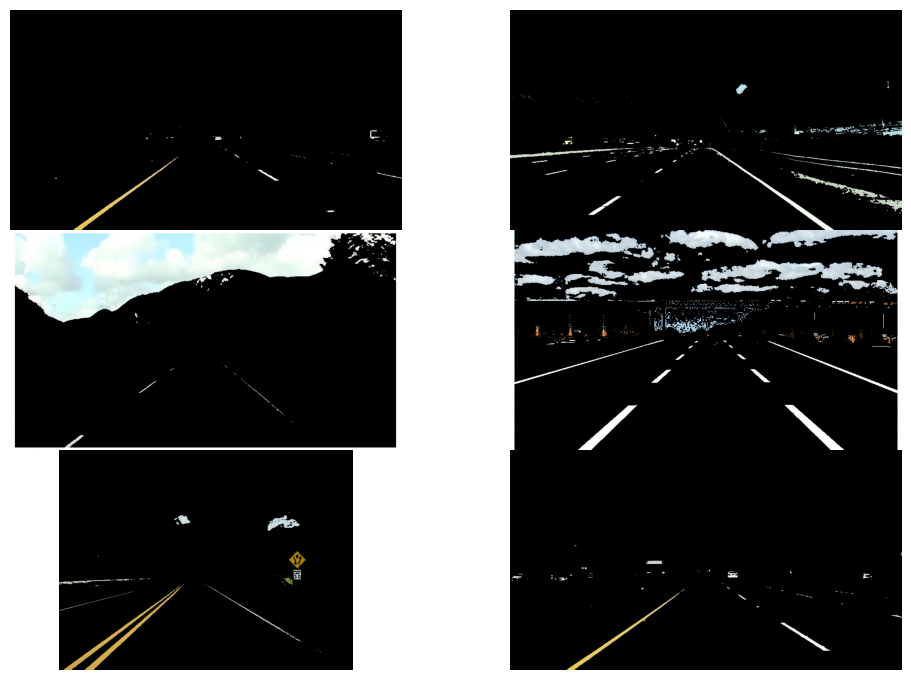

Images after Gray Scaling


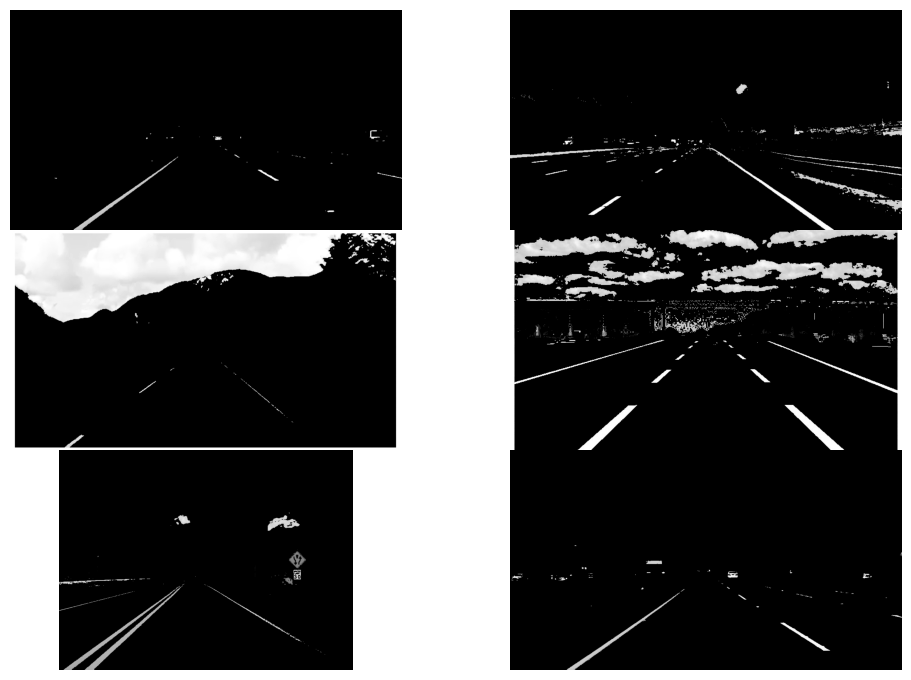

Images after Gaussian Smoothing


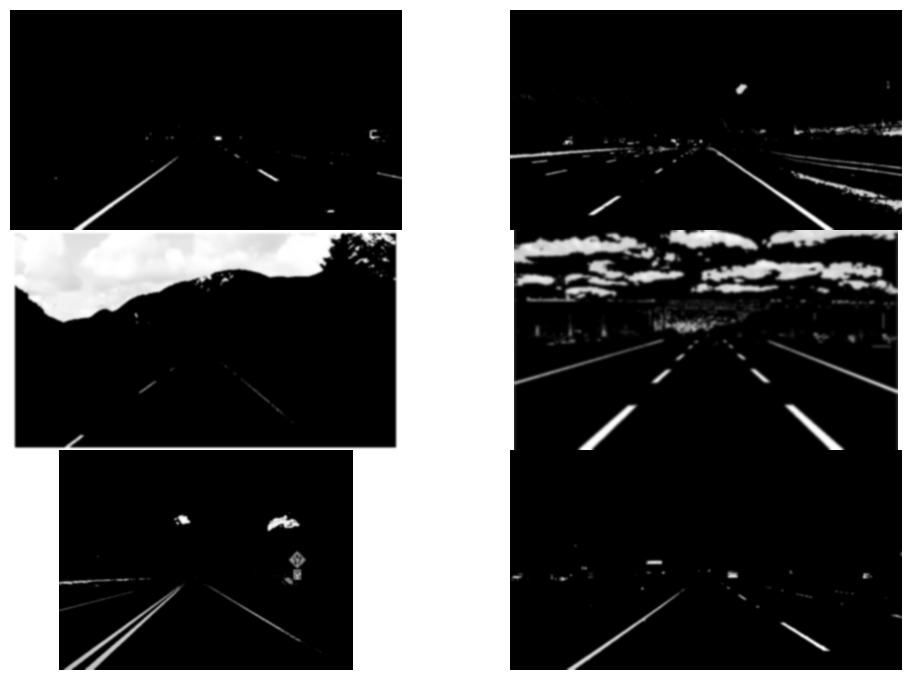

Images after Canny Edge Detection


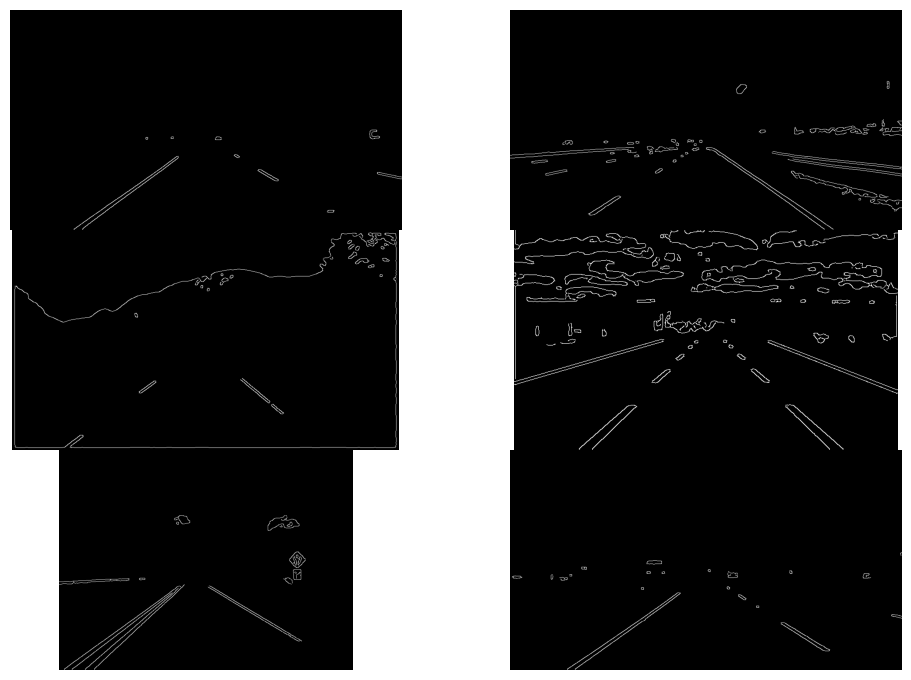

Images after finding the Region of Interest


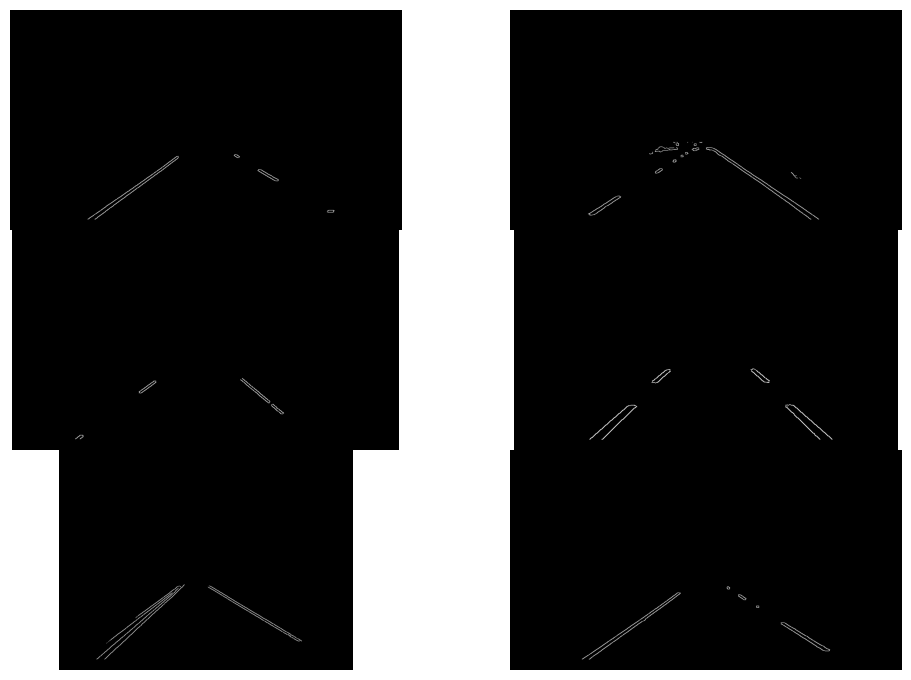

Images after applying Hough Transform


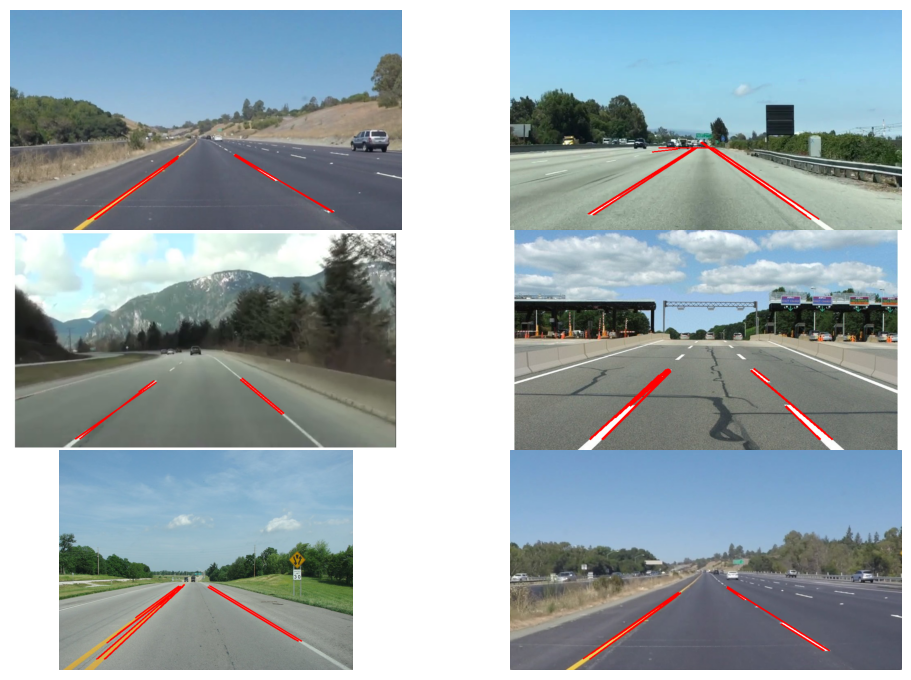

Images after applying Averaging and Extrapolation


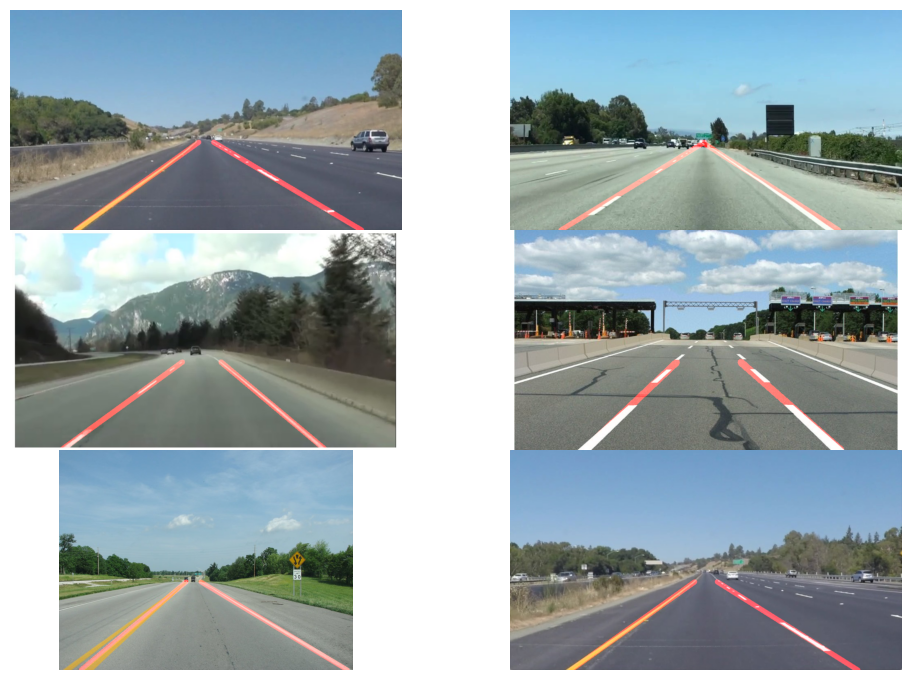

In [2]:
#Straight Lane Line Detection
!pip install opencv-python
!pip install moviepy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from moviepy import *
from IPython.display import HTML
from IPython.display import Image
%matplotlib inline

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def apply_gaussian_blur(img, size=13):
    return cv2.GaussianBlur(img, (size, size), 0)

def detect_edges(img, lo_thres=50, hi_thres=150):
    return cv2.Canny(img, lo_thres, hi_thres)

def change_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def change_to_hsl(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def overlay_lane_lines(img, detected_lines, line_color=[255, 0, 0], line_thickness=12):
    overlay_img = np.zeros_like(img)
    for line in detected_lines:
        if line is not None:
            cv2.line(overlay_img, *line, line_color, line_thickness)
    return cv2.addWeighted(img, 1.0, overlay_img, 1.0, 0.0)

def display_images(image_list, num_cols=2, num_rows=5, color_map=None):
    plt.figure(figsize=(10, 11))
    for idx, img in enumerate(image_list):
        plt.subplot(num_rows, num_cols, idx + 1)
        color_map = 'gray' if img.ndim == 2 else color_map
        plt.imshow(img, cmap=color_map)
        plt.axis('off')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def filter_RGB_colors(img):
    lower_white = np.uint8([200, 200, 200])
    upper_white = np.uint8([255, 255, 255])
    wmas = cv2.inRange(img, lower_white, upper_white)
    lower_yellow = np.uint8([175, 175, 0])
    upper_yellow = np.uint8([255, 255, 255])
    ymas = cv2.inRange(img, lower_yellow, upper_yellow)
    collectivemas = cv2.bitwise_or(wmas, ymas)
    result_image = cv2.bitwise_and(img, img, mask=collectivemas)
    return result_image

def filter_colors_in_HSV(img):
    hsv_image = change_to_hsv(img)
    lower_white = np.uint8([0, 0, 210])
    upper_white = np.uint8([255, 30, 255])
    wmas = cv2.inRange(hsv_image, lower_white, upper_white)
    lower_yellow = np.uint8([18, 80, 80])
    upper_yellow = np.uint8([30, 255, 255])
    ymas = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    collectivemas = cv2.bitwise_or(wmas, ymas)
    result_img = cv2.bitwise_and(img, img, mask=collectivemas)
    return result_img

def apply_region_mask(img):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        mask_color = (255,) * channel_count
    else:
        mask_color = 255  
    ro, col = img.shape[:2]
    lower_left = [col * 0.1, ro * 0.95]
    upper_left = [col * 0.4, ro * 0.6]
    lower_right = [col * 0.9, ro * 0.95]
    upper_right = [col * 0.6, ro * 0.6]
    polygon_points = np.array([[lower_left, upper_left, upper_right, lower_right]], dtype=np.int32)
    cv2.fillPoly(mask, polygon_points, mask_color)
    region_selected_image = cv2.bitwise_and(img, mask)
    return region_selected_image

def select_colors_in_HSL(img):
    hsl_image = change_to_hsl(img)
    lower_white = np.uint8([0, 200, 0])
    upper_white = np.uint8([255, 255, 255])
    wmas = cv2.inRange(hsl_image, lower_white, upper_white)
    lower_yellow = np.uint8([10, 0, 100])
    upper_yellow = np.uint8([40, 255, 255])
    ymas = cv2.inRange(hsl_image, lower_yellow, upper_yellow)
    collectivemas = cv2.bitwise_or(wmas, ymas)
    final_image = cv2.bitwise_and(img, img, mask=collectivemas)
    return final_image

def apply_hough_line_detection(img):
    distance_resolution = 1 
    angle_resolution = np.pi / 180  
    count_thresh = 20  
    min_line_length = 20  
    max_gap_between_lines = 300 
    lines = cv2.HoughLinesP(img, rho=distance_resolution, theta=angle_resolution, threshold=count_thresh,
                            minLineLength=min_line_length, maxLineGap=max_gap_between_lines)
    return lines

def draw_lines_on_image(img, detected_lines, line_color=[255, 0, 0], line_thickness=2):
    img_copy = np.copy(img)
    for line in detected_lines:
        for start_x, start_y, end_x, end_y in line:
            cv2.line(img_copy, (start_x, start_y), (end_x, end_y), line_color, line_thickness)
    return img_copy

def calculate_average_lines(lines):
    left_lane_lines = []  
    left_lane_weights = []  
    right_lane_lines = [] 
    right_lane_weights = [] 
    for line in lines:
        for a, b, c, d in line:
            if a == c:  
                continue
            sl = (d - b) / (c - a)
            intr = b - sl * a
            len = np.sqrt((d - b)**2 + (c - a)**2)
            if sl < 0: 
                left_lane_lines.append((sl, intr))
                left_lane_weights.append(len)
            else: 
                right_lane_lines.append((sl, intr))
                right_lane_weights.append(len)
    left_avg = np.dot(left_lane_weights, left_lane_lines) / np.sum(left_lane_weights) if left_lane_weights else None
    right_avg = np.dot(right_lane_weights, right_lane_lines) / np.sum(right_lane_weights) if right_lane_weights else None
    return left_avg, right_avg

def calculate_endpoints(y_start, y_end, line_parameters):
    if line_parameters is None:
        return None
    sl, intr = line_parameters
    x_start = int((y_start - intr) / sl)
    x_end = int((y_end - intr) / sl)
    y_start = int(y_start)
    y_end = int(y_end)
    return ((x_start, y_start), (x_end, y_end))

def extract_lane_lines(img, detected_lines):
    left_avg_line, right_avg_line = calculate_average_lines(detected_lines)
    bottom_y = img.shape[0]  
    top_y = bottom_y * 0.6  
    left_line_coords = calculate_endpoints(bottom_y, top_y, left_avg_line)
    right_line_coords = calculate_endpoints(bottom_y, top_y, right_avg_line)
    return left_line_coords, right_line_coords

def display_rgb_color_selection(test_images):
    print("Images after RGB Color Selection")
    display_images(list(map(filter_RGB_colors, test_images)))

def display_hsv_color_selection(test_images):
    print("Images converted to HSV Color Space")
    display_images(list(map(change_to_hsv, test_images)))
    print("Images after HSV Color Selection")
    display_images(list(map(filter_colors_in_HSV, test_images)))

def display_hsl_color_selection(test_images):
    print("Images converted to HSL Color Space")
    display_images(list(map(change_to_hsl, test_images)))
    print("Images after HSL Color Selection")
    display_images(list(map(select_colors_in_HSL, test_images)))
    
def display_gray_scaling(test_images):
    color_selected_images = list(map(select_colors_in_HSL, test_images))
    scaled_images = list(map(convert_to_grayscale, color_selected_images))
    print("Images after Gray Scaling")
    display_images(scaled_images)
    return scaled_images
    
def display_gaussain_smoothing(scaled_images):
    smoothed_images = list(map(apply_gaussian_blur, scaled_images))
    print("Images after Gaussian Smoothing")
    display_images(smoothed_images)
    return smoothed_images

def display_canny_edge_detection(smoothed_images):
    edge_detected_images = list(map(detect_edges, smoothed_images))
    print("Images after Canny Edge Detection")
    display_images(edge_detected_images)
    roi_image = list(map(apply_region_mask, edge_detected_images))
    print("Images after finding the Region of Interest")
    display_images(roi_image)
    return roi_image

def display_hough_tranform(roi_image, test_images):
    transformed_lines = list(map(apply_hough_line_detection, roi_image))
    line_images = []
    for image, lines in zip(test_images, transformed_lines):
        line_images.append(draw_lines_on_image(image, lines))
    print("Images after applying Hough Transform")
    display_images(line_images)
    lane_images = []
    for image, lines in zip(test_images, transformed_lines):
        lane_images.append(overlay_lane_lines(image, extract_lane_lines(image, lines)))
    print("Images after applying Averaging and Extrapolation")
    display_images(lane_images)

def processing_frames(img):
    hsl_filtered = select_colors_in_HSL(img)
    grayscale_img = convert_to_grayscale(hsl_filtered)
    blurred_img = apply_gaussian_blur(grayscale_img)
    edge_img = detect_edges(blurred_img)
    masked_img = apply_region_mask(edge_img)
    lines = apply_hough_line_detection(masked_img)
    final_result = overlay_lane_lines(img, extract_lane_lines(img, lines))
    return final_result

def process_input_video(input_file, output_file):
    video_clip = VideoFileClip(os.path.join('test_videos_straight', input_file), audio=False)
    processed_clip = video_clip.fl_image(processing_frames)
    processed_clip.write_videofile(os.path.join('output_videos', output_file), audio=False)

def main():
    test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
    print("Input Test Images")
    display_images(test_images)
    display_rgb_color_selection(test_images)
    display_hsv_color_selection(test_images)
    display_hsl_color_selection(test_images)
    scaled_images = display_gray_scaling(test_images)
    smoothed_images = display_gaussain_smoothing(scaled_images)
    roi_image = display_canny_edge_detection(smoothed_images)
    display_hough_tranform(roi_image, test_images)
    
if __name__ == "__main__":
    main()

In [3]:
#Test Video with Solid White Right Line
%time process_input_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidWhiteRight_output.mp4"))

Moviepy - Building video output_videos/solidWhiteRight_output.mp4.
Moviepy - Writing video output_videos/solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidWhiteRight_output.mp4
CPU times: user 1.69 s, sys: 407 ms, total: 2.1 s
Wall time: 2.29 s


In [4]:
#Test Video with Solid Yellow Left Line
%time process_input_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidYellowLeft_output.mp4"))

Moviepy - Building video output_videos/solidYellowLeft_output.mp4.
Moviepy - Writing video output_videos/solidYellowLeft_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidYellowLeft_output.mp4
CPU times: user 5.4 s, sys: 1.23 s, total: 6.63 s
Wall time: 6.34 s


In [7]:
#Curved Lane Line Detection

def curvature_values(lrad, rrad, rad):
    vi = np.zeros((720, 300, 3), dtype='uint8')
    vi[:, :, 0] = 249
    vi[:, :, 1] = 242
    vi[:, :, 2] = 227
    cv2.putText(vi, f'Left Curvature: ', (10, 150), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'{lrad}', (10, 180), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'', (10, 210), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'Right Curvature: ', (10, 240), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'{rrad}', (10, 270), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'', (10, 300), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'Average Curvature: ', (10, 330), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'{rad}', (10, 360), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(vi, f'', (10, 390), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0, 255, 0), 2)
    return vi

def vehicle_turn_values(img, rad):
    if rad >= 10000:
        img = cv2.putText(img, 'Go Straight', (50,50), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255,255,0), 2, cv2.LINE_AA)
    if rad >= 0 and rad < 10000:
        img = cv2.putText(img, 'Turn Right', (50,50), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255,255,0), 2, cv2.LINE_AA)
    if rad <= 0:
        img = cv2.putText(img, 'Turn Left', (50,50), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255,255,0), 2, cv2.LINE_AA)
    return img

def detect_and_mask(image_yw, fr):
    h1, w1 = image_yw.shape
    fig = [(int(w1*0.15), h1-1), (int(w1*0.45), int(h1*0.62)), (int(w1*0.58), int(h1*0.62)), (int(w1*0.95), h1-1)]
    mi = roi(image_yw, fig)
    return mi

def overlay_results(fr, areafill_unwarp, lf, rf, wim):
    vid1 = cv2.addWeighted(fr, 1, areafill_unwarp, 1, 0)
    lrad, rrad, avg_radius = calculate_curvature(wim, lf, rf)
    vid2 = curvature_values(lrad, rrad, avg_radius)
    out_res = combine_frames(vid1, vid2)
    out_res = vehicle_turn_values(out_res, avg_radius)
    return out_res

def detect_curves_and_fill(op, w1, h1):
    lf, rf = curve_fitting_main(op)
    pl, pr = calculating_curve_pixels((960, 400), lf, rf)
    areafill = curve_filling_between_lanes((960, 400), pl, pr)
    areafill_unwarp = image_unwrapping(areafill, psrc, pdes, (w1, h1))
    return areafill_unwarp, lf, rf
    
def detect_yellow_white_lane(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(fr, cv2.COLOR_BGR2HSV)
    blr = cv2.GaussianBlur(g,(5,5),0)
    wm = cv2.threshold(blr,200,255,cv2.THRESH_BINARY)[1]
    ly = np.array([0,100,100])
    uy = np.array([210,255,255])
    ym = cv2.inRange(hsv, ly, uy)
    q = cv2.bitwise_or(wm, ym)
    return q

def transform_perspective(mi, w1, h1):
    psrc = np.float32([(int(w1*0.49), int(h1*0.62)), (int(w1*0.58), int(h1*0.62)), (int(w1*0.15), h1-1), (int(w1*0.95), h1-1)])
    pdes = np.float32([(0, 0), (400, 0), (0, 960), (400, 960)])
    wim = image_wrapping(mi, psrc, pdes, (400, 960))
    return wim, psrc, pdes

def left_right_curve_fitting(img):
    fig = np.sum(img[img.shape[0]//2:,:], axis=0)
    midi = int(fig.shape[0]/2)
    bx = np.argmax(fig[:midi])
    rx = np.argmax(fig[midi:]) + midi
    num = 50
    mar = 100
    mpx = 50
    win_ht = int(img.shape[0]/num)
    return win_ht, mar, num, bx, rx, mpx

def image_wrapping(img, psrc, pdes, destn_size):
    mat = cv2.getPerspectiveTransform(psrc, pdes)
    wim = cv2.warpPerspective(img, mat, destn_size)
    return wim

def roi(img, fig):
    mask = np.zeros_like(img)
    region_points = np.array([fig], dtype=np.int32)
    cv2.fillPoly(mask, region_points, 1)
    mi = img * mask
    return mi

def image_unwrapping(img, psrc, pdes, source_size):
    mat = cv2.getPerspectiveTransform(pdes, psrc)
    img_unwarp = cv2.warpPerspective(img, mat, source_size)
    return img_unwarp
    
def curve_fitting_minor(img):
    idx_left = []
    idx_right = []  
    y, x = img.nonzero()
    win_ht, mar, num, bx, rx, mpx = left_right_curve_fitting(img)
    pre_l = bx
    pre_r = rx
    for i in range(num):
        lo_rx = pre_r - mar
        hi_rx = pre_r + mar
        lo_lx = pre_l - mar
        hi_lx = pre_l + mar
        lo = img.shape[0] - (i+1)*win_ht
        hi = img.shape[0] - i*win_ht
        idxl = ((y >= lo) & (y < hi) & (x >= lo_lx) & (x < hi_lx)).nonzero()[0]
        idxr  = ((y >= lo) & (y < hi) & (x >= lo_rx) & (x < hi_rx)).nonzero()[0]
        idx_left.append(idxl)
        idx_right.append(idxr)
        if len(idxl) > mpx:
            pre_l = int(np.mean(x[idxl]))
        if len(idxr) > mpx:
            pre_r = int(np.mean(x[idxr]))
    idx_left = np.concatenate(idx_left)
    idx_right = np.concatenate(idx_right)
    return idx_left, idx_right, y, x

def release_resources(video, out):
    video.release()
    out.release()

def curve_fitting_main(img):
    idx_left, idx_right, y, x = curve_fitting_minor(img)
    x_l = x[idx_left]
    y_l = y[idx_left]
    x_r = x[idx_right]
    y_r = y[idx_right]
    lf = np.polyfit(y_l, x_l, 2)
    rf = np.polyfit(y_r, x_r, 2)
    return lf, rf

def calculating_curve_pixels(img_shape, lf, rf):
    plt = np.linspace(0, img_shape[0]-1, img_shape[0])
    lfitx = lf[0]*plt**2 + lf[1]*plt + lf[2]
    rfitx = rf[0]*plt**2 + rf[1]*plt + rf[2]
    pl = np.array([np.transpose(np.vstack([lfitx, plt]))])
    pr = np.array([np.flipud(np.transpose(np.vstack([rfitx, plt])))])
    return pl, pr

def curve_filling_between_lanes(img_shape, pl, pr):
    p1 = np.hstack((pl, pr))
    img = np.zeros((img_shape[0], img_shape[1], 3), dtype='uint8')
    cv2.fillPoly(img, np.int_([p1]), (0,0, 255))
    return img

def combine_frames(img1,img5):
    img1 = cv2.resize(img1, (980, 720), interpolation=cv2.INTER_AREA)
    out_res = np.concatenate((img1, img5), axis=1)
    return out_res

def calculate_curvature(img, lf, rf):
    v = img.shape[0]/2
    lrad = ((1 + (2*lf[0]*v + lf[1])**2)**1.5) / (2*lf[0])
    rrad = ((1 + (2*rf[0]*v + rf[1])**2)**1.5) / (2*rf[0])
    avg_radius = (lrad+rrad)/2
    return round(lrad,2), round(rrad,2), round(avg_radius,2)

def process_image(wim):
    k = np.ones((11,11), np.uint8)
    op = cv2.morphologyEx(wim, cv2.MORPH_CLOSE, k)
    return op

video = cv2.VideoCapture("test_videos/challenge.mp4")
out = cv2.VideoWriter('challenge_video_output.avi',cv2.VideoWriter_fourcc(*'XVID'), 25, (1280,720))
print("Input video successfully loaded!")
print("Starting Processing.....")

while True:
    isTrue, fr = video.read()
    if not isTrue:
        break
    g = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    th = cv2.threshold(g,200,255,cv2.THRESH_BINARY)[1]
    image_yw = detect_yellow_white_lane(fr)
    mi = detect_and_mask(image_yw, fr)
    wim, psrc, pdes = transform_perspective(mi, fr.shape[1], fr.shape[0])
    op = process_image(wim)
    areafill_unwarp, lf, rf = detect_curves_and_fill(op, fr.shape[1], fr.shape[0])
    out_res = overlay_results(fr, areafill_unwarp, lf, rf, wim)
    out.write(out_res)

release_resources(video, out)
print(" ")
print("Lane Line Detection video generated successfully!")

Input video successfully loaded!
Starting Processing.....
 
Lane Line Detection video generated successfully!
